In [16]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle
from random import randint
from scipy.linalg import qr

BAD = ['VT', 'VFb', 'VFt'] # KIS,S

In [2]:
# DEFINE WHERE ALL OF THE FILES ARE - UNLABED EXCEPT BY NAME
dir_path = r'C:\Users\jodge\Documents\School\Summer24\tinyml_contest_data_training'
directory_files = os.listdir(dir_path)
num_files = len(directory_files)

# GET INFO TO ACCESS THOSE FILES
root_project_path = r'C:\Users\jodge\Documents\School\Summer24\tinymlcontest2022_demo_example'
label_filename = r'label_list.csv' # in demo path - Maps abbrevations to full medical names of conditions. small file.
indices_path = os.path.join(root_project_path, 'data_indices')

test_filename = r'test_indice.csv'  # in label path
train_filename = r'train_indice.csv' # in label path

test_path = os.path.join(indices_path, test_filename)
train_path = os.path.join(indices_path, train_filename)

df_test_indices = pd.read_csv(test_path, sep=",", header=0)
df_train_indices = pd.read_csv(train_path, sep=",", header=0)

#####

label_path = os.path.join(root_project_path, label_filename)
df_labels = pd.read_csv(label_path, sep=',', header=0)

label_dict = {k : v for k,v in df_labels.values} # Afs : Atrial Fibrillation, etc.

In [18]:
def saveObj(obj, filename = "C.pkl"):
    with open(filename, 'wb') as file:
        pickle.dump(obj, file)

def readObj(filename = "C.pkl"):
    with open(filename, 'rb') as file:
       return pickle.load(file)

def readFile(filename):
    return pd.read_csv(os.path.join(dir_path, filename), header=None).to_numpy().flatten()

def getRandomFile(): #includes test and train, just a dummy testing helper method
    random_idx = randint(0,len(df_train_indices))
    filename = df_train_indices.Filename[random_idx]
    file_path = os.path.join(dir_path, filename)
    reader = pd.read_csv(file_path, sep = " ", header = None)
    return reader.to_numpy().flatten(), filename
    
def averageSignals(signals):
    arrays = [readFile(file) for file in signals]
    stacked = np.stack(arrays) 
    return np.mean(stacked, axis=0)
    
def getAveragedCategorySignals(): #only training data
    holder = {}
    signals = {}
    for label in label_dict.keys():
        holder[label] = [] # initialize holder 
    for filename in df_train_indices.Filename:
        temp = filename.split('-')
        cat = temp[1] # gets the label category
        holder[cat].append(filename)
        
    for label, file_list in holder.items():
        signals[label] = averageSignals(file_list)
    return signals

def getAverageSignal():
    return averageSignals(df_train_indices.Filename)

def getFullTrainSignalMatrix(): #all files with each as a column
    arrays = [readFile(file) for file in df_train_indices.Filename]
    return np.stack(arrays, axis=1)
    
def plotSignal(n, x, title, sampleLength = 5):
  t = np.linspace(0, sampleLength, n)
  plt.plot(t, x)
  plt.title(title)
  plt.xlabel("Time")
  plt.ylabel("Amplitude")
  plt.show()

def sampleSignal(C, x):
  return C @ x

In [29]:
def svd(x = getFullTrainSignalMatrix()):
    U, S, VT = np.linalg.svd(x, full_matrices=True)
    S = np.diag(S)
    return (U, S, VT)
    
def reconstruct(U, S, VT, r = 500):
    return U[:,:r] @ S[:r,:r] @ VT[:r,:]

def plotCumSum(S):
    plt.plot(np.cumsum(np.diag(S))/np.sum(np.diag(S)))
    plt.title('Singular Values: Cumulative Sum')
    plt.show()
    
# def plotRanksMSEs(U, S, VT, this_range = range(50, 1250, 100)):
#     ranks = []
#     mses = []
#     for r in this_range:
#         Xapprox = reconstruct(U, S, VT, r)
#         mse = np.mean((fullTrainSignalMatrix - Xapprox) ** 2)
#         ranks.append(r)
#         mses.append(mse)
#     plt.plot(ranks, mses)
#     plt.title('MSE per Rank')
#     plt.show()
    
#     with open(r"results/svd_results.csv", "a+") as f:
#         for rank,mse in zip(ranks, mses):
#             f.write(f"{rank},{mse}\n")

reading from data\fullTrainMat.pkl


In [5]:
fullTrainSignalMatrix = getFullTrainSignalMatrix()
catSigs = getAveragedCategorySignals()
U, S, VT = svd(fullTrainSignalMatrix)

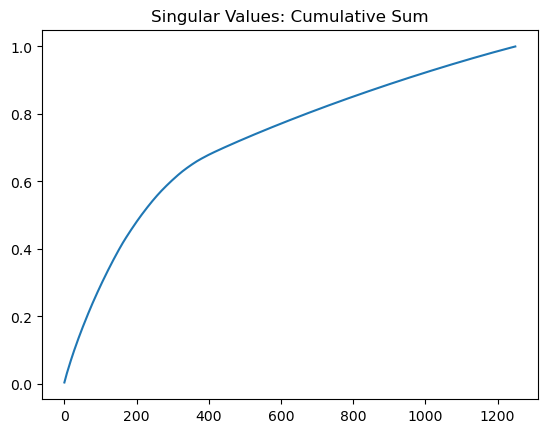

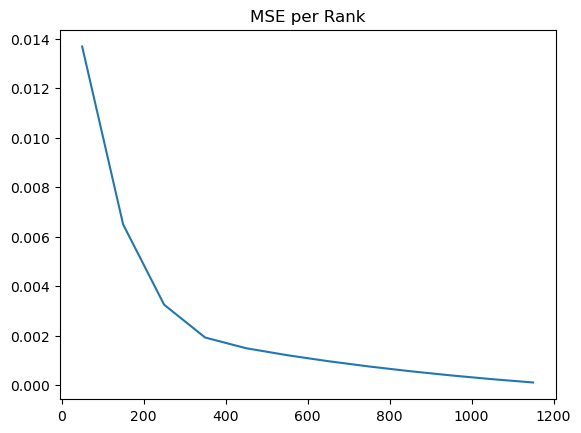

In [6]:
ranks = []
mses = []

for r in range(50, 1250, 100):
    Xapprox = reconstruct(U, S, VT, r)
    mse = np.mean((fullTrainSignalMatrix - Xapprox) ** 2)
    ranks.append(r)
    mses.append(mse)
    
plotCumSum(S)
plt.plot(ranks, mses)
plt.title('MSE per Rank')
plt.show()

with open(r"results/svd_results.csv", "a+") as f:
    for rank,mse in zip(ranks, mses):
        f.write(f"{rank},{mse}\n")

In [39]:
from scipy.linalg import qr
p = 500 # number of sensors
r = 400 # our truncated rank count
#print(f"p, r = {p}, {r}")

#reshape SVD according to r
U_hat, S_hat, VT_hat = U[:,:r], S[:r,:r], VT[:r,:]

Q, R, pivots = None, None, None

if (p == r):
    Q, R, pivots = qr(U_hat, pivoting = True) # or maybe just U
elif (p > r): # oversampled
    Q, R, pivots = qr(U_hat @ U_hat.T, pivoting = True) # or maybe just U
else:
    for _ in range(100):
        print("ERROR p < r")
pivots = pivots[:p]

# Create C matrix
C = np.zeros((p, fullTrainSignalMatrix.shape[0]))
print(f"C shape: {C.shape}")
C[np.arange(p), pivots] = 1

# print(f"U, S, VT shapes: {U_hat.shape}, {S_hat.shape}, {VT_hat.shape}")
# print(f"Q, R, pivots shapes: {Q.shape, R.shape, pivots.shape}")
# print(pivot)

C shape: (500, 1250)


In [5]:
def measureAndReconstruct(signal) -> float:
    # Measure a signal
    y = C @ signal
    
    # Solve for coefficients #CLAUDE assisted here down
    U_k_reduced = U_hat[:, :p][pivots, :]
    #print(C.shape, U_hat.shape, U_k_reduced.shape, y.shape, U_hat[:,:][pivots,:].shape)
    if p > r:
        a = np.linalg.lstsq(U_k_reduced, y, rcond=None)[0]
    else:
        a = np.linalg.pinv(C @ U_hat) @ y # idk how to make this work
      
    # Reconstruct the signal
    #x_reconstructed = U[:, :p] @ a
    x_reconstructed = U_hat @ a
    mseFinal = np.mean((signal - x_reconstructed) ** 2)
    return mseFinal

# for _ in range(10):
#     random_col = randint(0, len(fullTrainSignalMatrix))
#     signal = fullTrainSignalMatrix[:,random_col]
#     print(measureAndReconstruct(signal))

#catSigs = getAveragedCategorySignals()
#print(catSigs)
for label, signal in catSigs.items():
    #print(signal)
    print(label, "\tdeath\t" if label in BAD else "\tokay\t", measureAndReconstruct(signal))


NameError: name 'catSigs' is not defined

# Per Person Exploration

In [20]:
def readObj(filename):
    print(f"reading from {filename}")
    with open(filename, 'rb') as file:
       return pickle.load(file)
def saveObj(obj, filename):
    print(f"saving to {filename}")
    with open(filename, 'wb') as file:
        pickle.dump(obj, file)  

class SVD:
    def __init__(self, U, S, VT):
        self.U = U
        self.S = S
        self.VT = VT

class ProblemSetup:
  def __init__(self, r, p, truncSVD, Q, R, pivots, C): #fullSVD,
      self.r = r # ranks to use
      self.p = p # number of sensors
      #self.fullSVD = fullSVD
      self.truncSVD = truncSVD
      self.Q = Q
      self.R = R
      self.pivots = pivots
      self.C = C
      
def getFullTrainSignalMatrix(): #all files with each as a column
    pkl_name = r"fullTrainMat.pkl"
    pkl_loc = os.path.join("data", pkl_name)

    if os.path.exists(pkl_loc):
        answer = readObj(pkl_loc)
        return answer
    else:
        print(f"{pkl_loc} not found - see other notebooks for generation")
        
def processData(trainingData, label, r = 400, p = 500): # r = ranks desired, p = num sensors. bug when r=p, math is hard.
    pkl_name = f"{label}_r{r}_p{p}.pkl"
    pkl_loc = os.path.join("data", pkl_name)

    if os.path.exists(pkl_loc):
        answer = readObj(pkl_loc)
        return answer
    
    U, S, VT = svd(trainingData)
    #full_SVD = SVD(U, S, VT)
    
    #reshape SVD according to r
    U_hat, S_hat, VT_hat = U[:,:r], S[:r,:r], VT[:r,:]
    trunc_SVD = SVD(U_hat, S_hat, VT_hat)
    
    Q, R, pivots = None, None, None
    if (p == r):
        Q, R, pivots = qr(U_hat, pivoting = True) # or maybe just U
    elif (p > r): # oversampled
        Q, R, pivots = qr(U_hat @ U_hat.T, pivoting = True) # or maybe just U
    else:
        for _ in range(100):
            print("ERROR p < r")
            
    pivots = pivots[:p]
    
    # Create C matrix
    C = np.zeros((p, getFullTrainSignalMatrix().shape[0]))
    #print(C.shape, pivots.shape)
    C[np.arange(p), pivots] = 1

    problemSetup = ProblemSetup(r, p,  trunc_SVD, Q, R, pivots, C) #full_SVD,
    #filename = os.path.join("data", label + ".pkl")
    saveObj(problemSetup, pkl_loc)
    
    return problemSetup
    
def svd(x = getFullTrainSignalMatrix()):
    U, S, VT = np.linalg.svd(x, full_matrices=True) #full_matrices=False
    S = np.diag(S)
    return (U, S, VT)

def measureAndReconstruct(problemSetup, signal):
    # Measure a signal
    C, U_hat, p, r, pivots =  problemSetup.C, problemSetup.truncSVD.U, problemSetup.p, problemSetup.r, problemSetup.pivots
    y = C @ signal
    
    # Solve for coefficients
    U_k_reduced = U_hat[:, :p][pivots, :] # suggested to try
    #print("cond", np.linalg.cond(U_k_reduced), np.linalg.cond(U_hat))
    
    if p == r:
        #a = np.linalg.lstsq(U_k_reduced, y, rcond=None)[0]
        #a = np.linalg.solve(C @ U_hat, y)
        #a = np.linalg.pinv(U_k_reduced) @ y
        #reg_param = 1e-6
        #a = np.linalg.lstsq(U_k_reduced + reg_param * np.eye(U_k_reduced.shape[0]), y, rcond=None)[0]
        #a = np.linalg.inv(C @ U_hat) @ y
        a = np.linalg.lstsq(C @ U_hat, y, rcond=None)[0]
    else:
        a = np.linalg.pinv(C @ U_hat) @ y

    x_reconstructed = U_hat @ a
    mseFinal = np.mean((signal - x_reconstructed) ** 2)
    return mseFinal, x_reconstructed

reading from data\fullTrainMat.pkl


In [11]:
patient_nums = set()
for fi in directory_files:
    parts = fi.split('-')
    patient_nums.add(parts[0][1:])
#patient_nums

{'01',
 '02',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '12',
 '13',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '34',
 '35',
 '36',
 '37',
 '40',
 '41',
 '43',
 '44',
 '45',
 '46',
 '48',
 '49',
 '50',
 '51',
 '53',
 '56',
 '57',
 '58',
 '59',
 '60',
 '62',
 '63',
 '64',
 '65',
 '66',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '79',
 '80',
 '81',
 '82',
 '85',
 '86',
 '88',
 '89',
 '90',
 '91',
 '93',
 '94',
 '95'}

S44 has 390 files
(1250, 390) (390, 390) (390, 390)


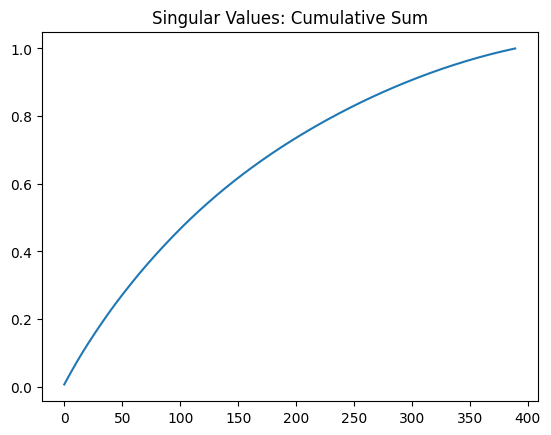

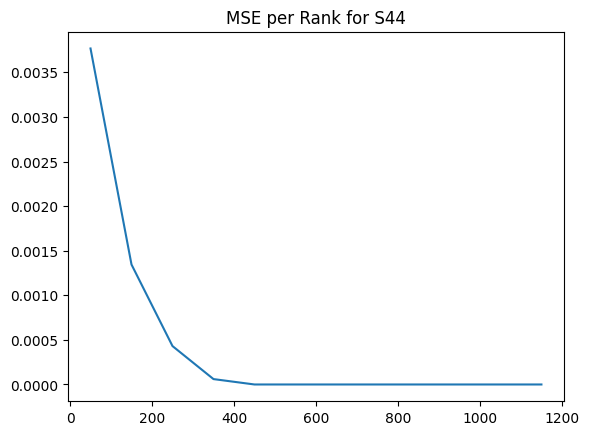

S10 has 391 files
(1250, 391) (391, 391) (391, 391)


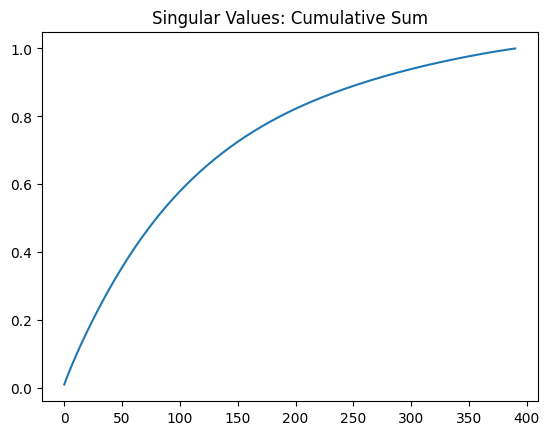

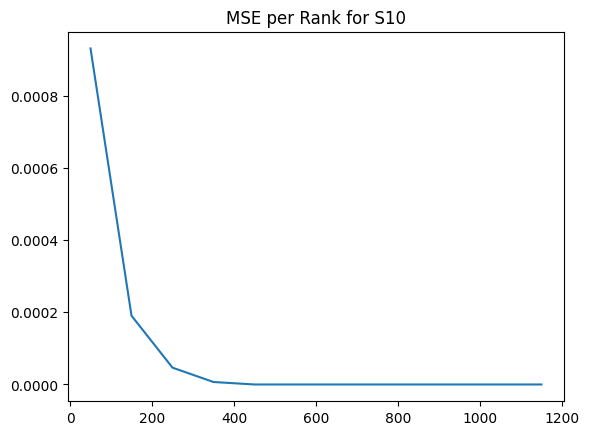

S05 has 219 files
(1250, 219) (219, 219) (219, 219)


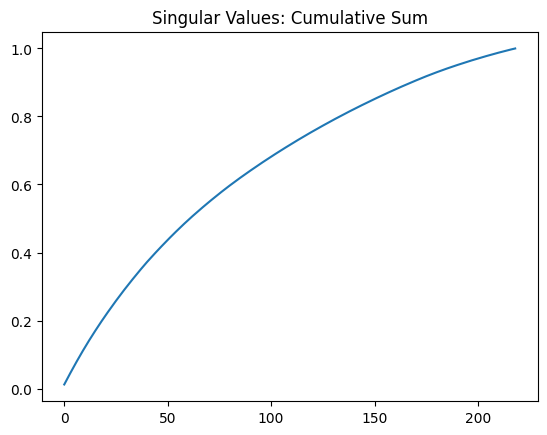

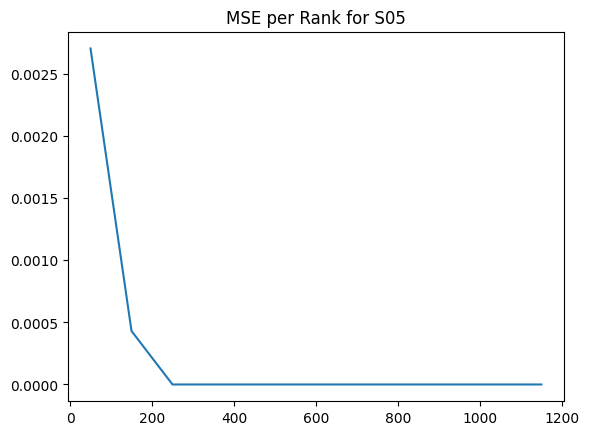

S50 has 39 files
(1250, 39) (39, 39) (39, 39)


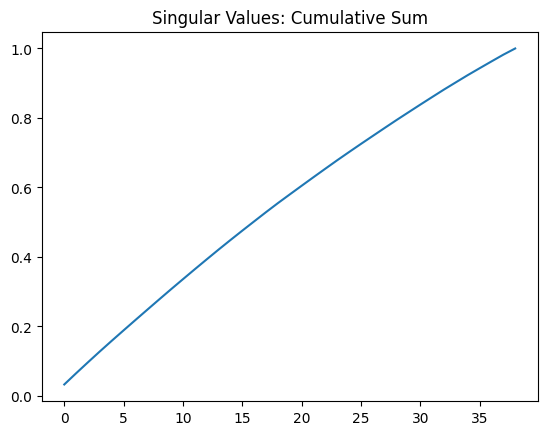

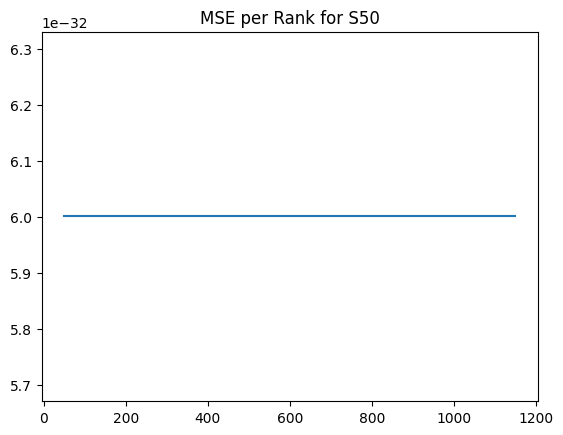

S60 has 104 files
(1250, 104) (104, 104) (104, 104)


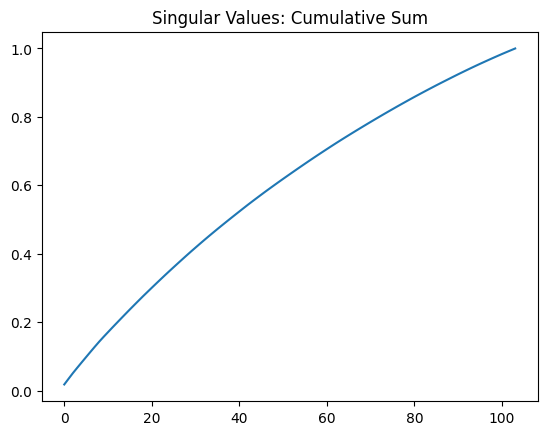

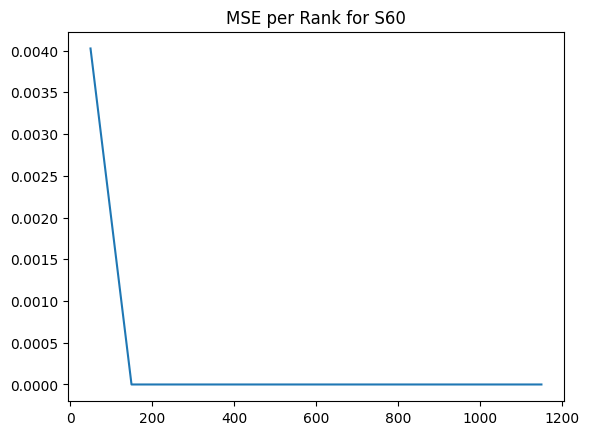

S15 has 454 files
(1250, 454) (454, 454) (454, 454)


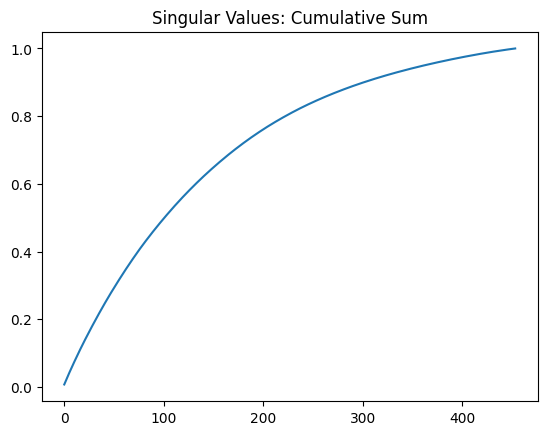

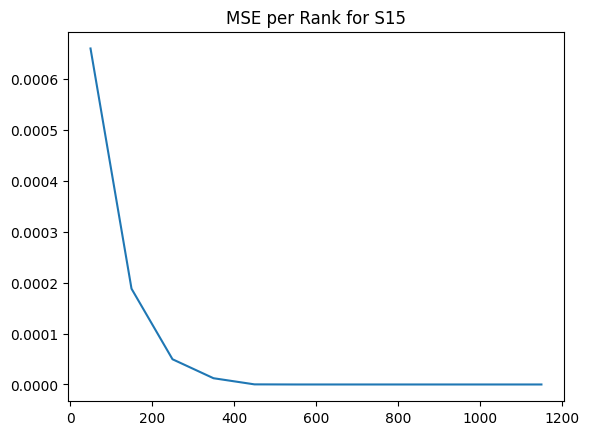

patient number 41 doesn't have any training data
S69 has 227 files
(1250, 227) (227, 227) (227, 227)


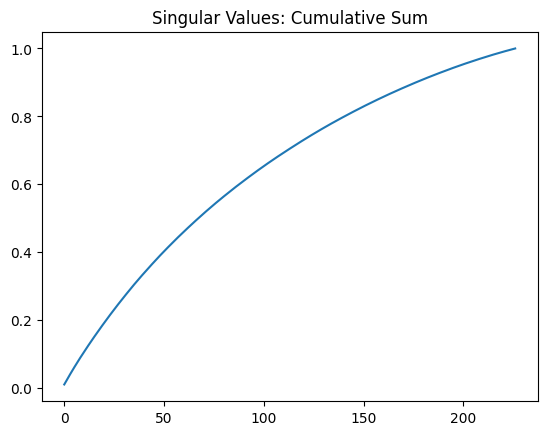

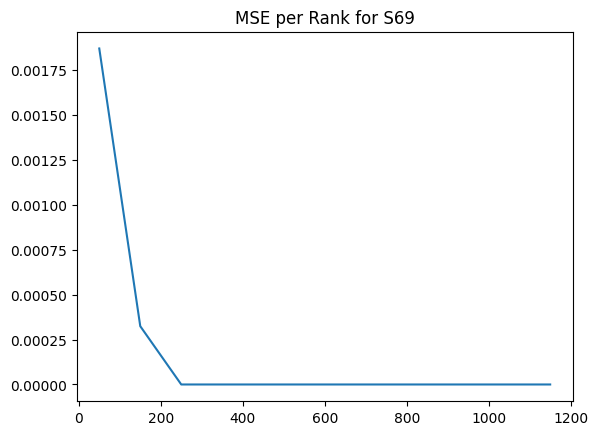

S49 has 74 files
(1250, 74) (74, 74) (74, 74)


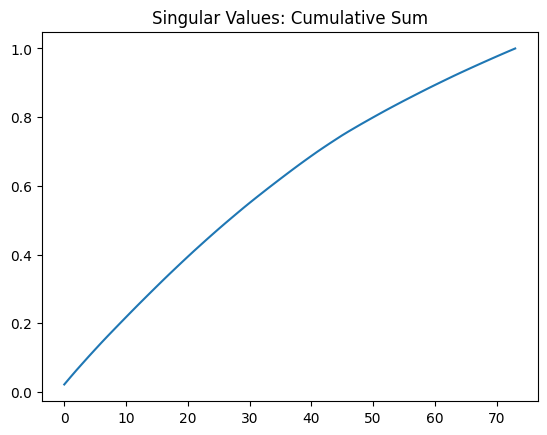

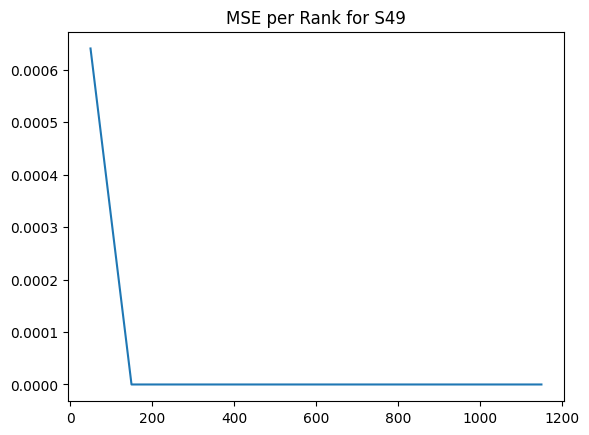

S25 has 166 files
(1250, 166) (166, 166) (166, 166)


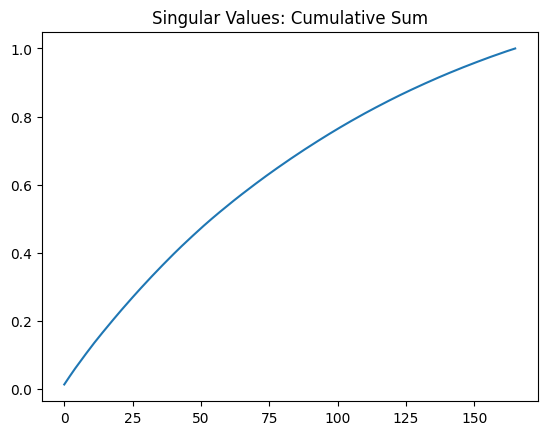

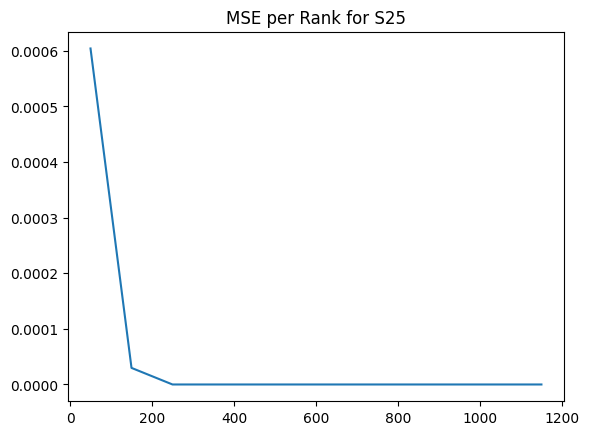

S36 has 169 files
(1250, 169) (169, 169) (169, 169)


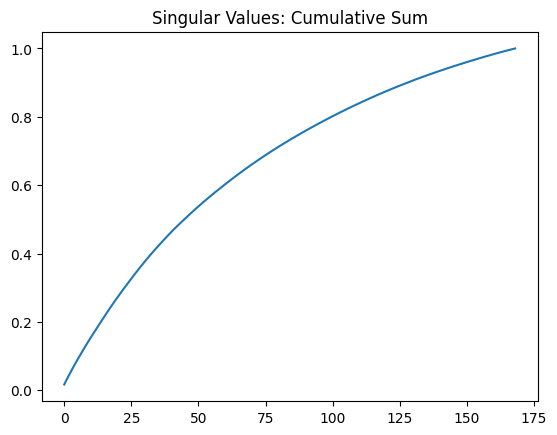

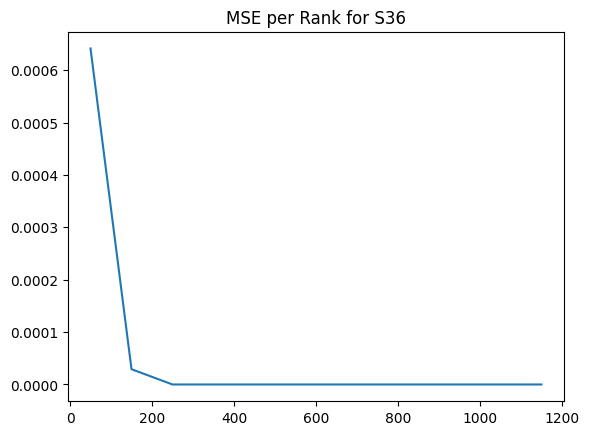

patient number 01 doesn't have any training data
patient number 21 doesn't have any training data
patient number 63 doesn't have any training data
S53 has 139 files
(1250, 139) (139, 139) (139, 139)


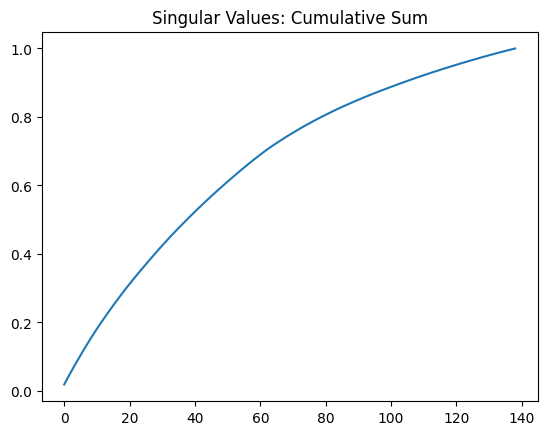

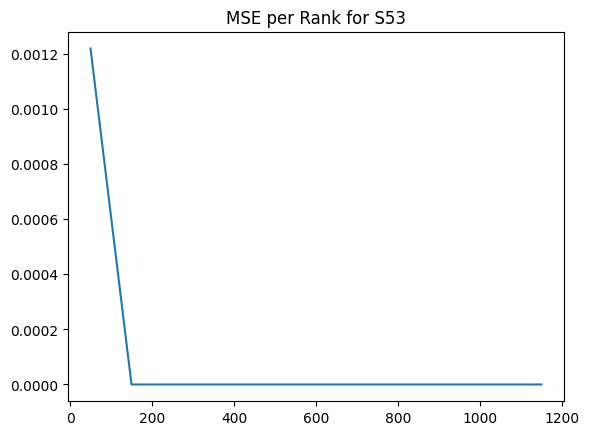

S81 has 55 files
(1250, 55) (55, 55) (55, 55)


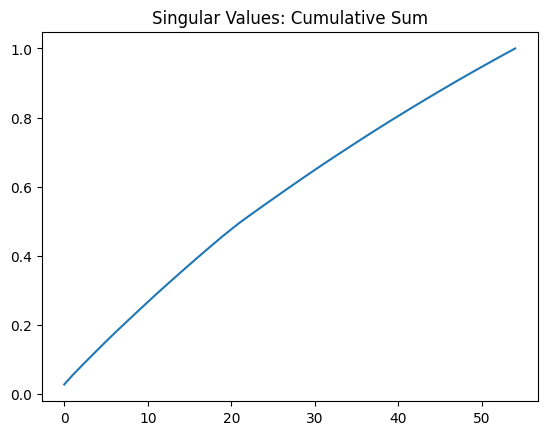

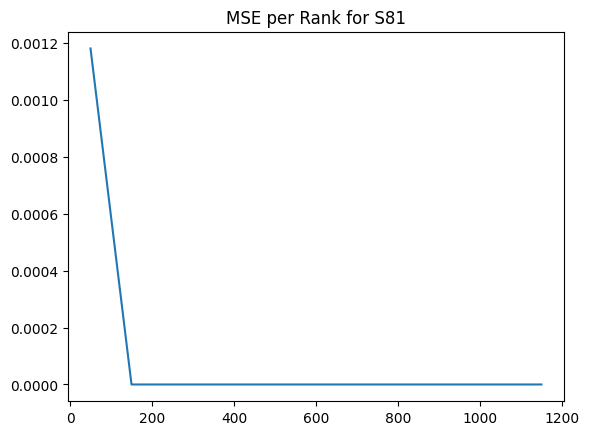

patient number 95 doesn't have any training data
patient number 06 doesn't have any training data
patient number 09 doesn't have any training data
S93 has 143 files
(1250, 143) (143, 143) (143, 143)


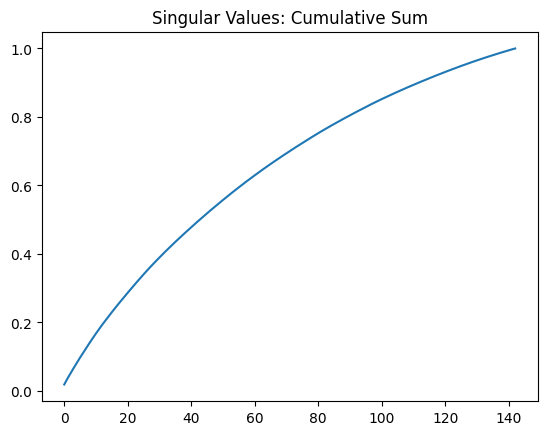

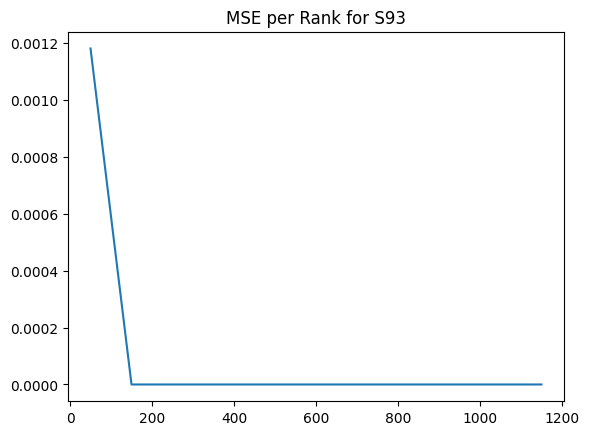

S07 has 89 files
(1250, 89) (89, 89) (89, 89)


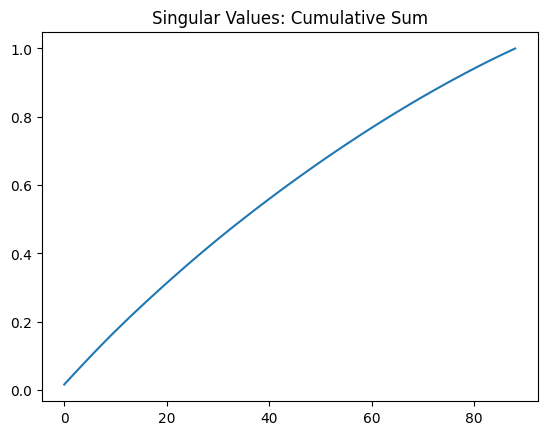

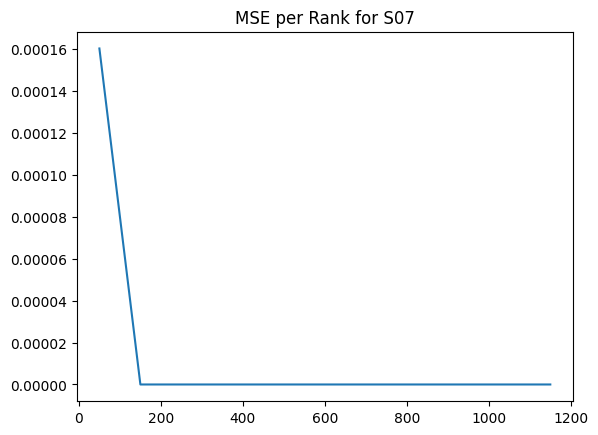

patient number 27 doesn't have any training data
S71 has 87 files
(1250, 87) (87, 87) (87, 87)


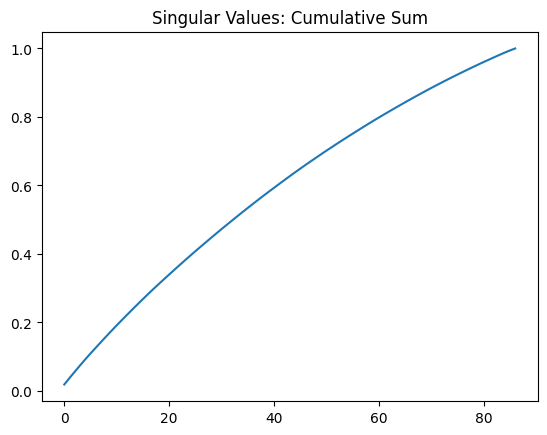

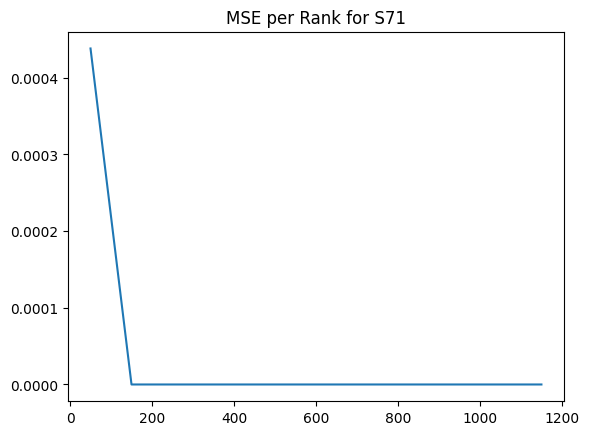

patient number 19 doesn't have any training data
S37 has 115 files
(1250, 115) (115, 115) (115, 115)


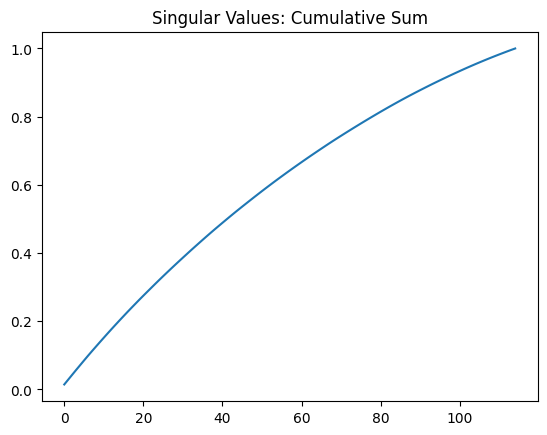

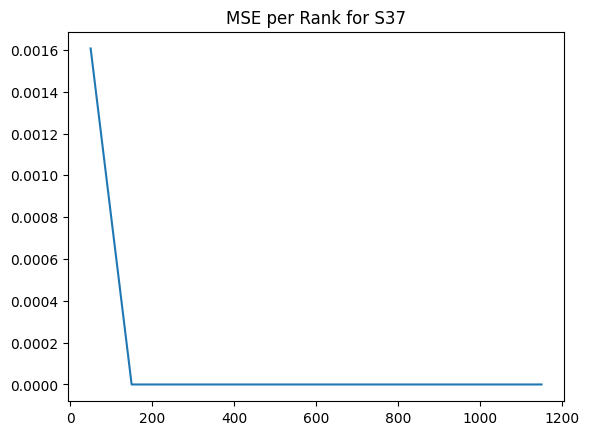

S94 has 436 files
(1250, 436) (436, 436) (436, 436)


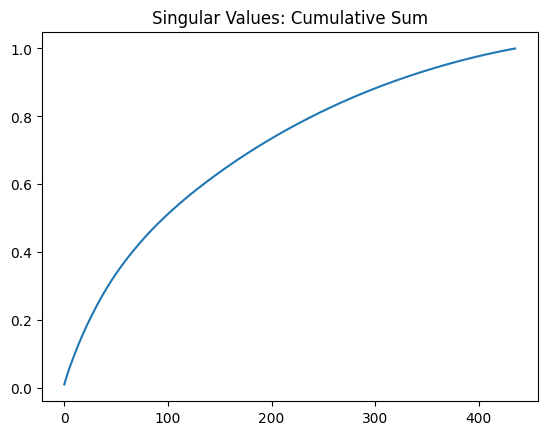

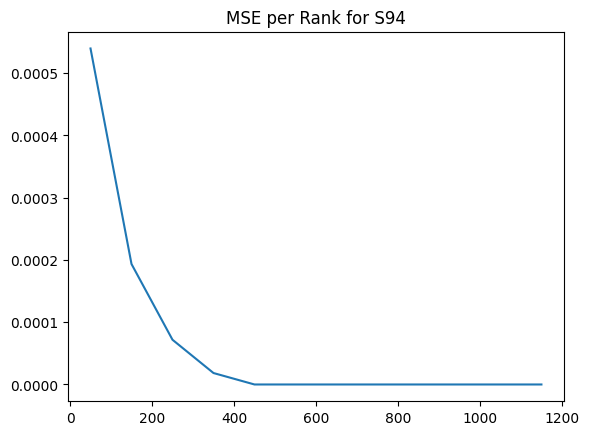

patient number 18 doesn't have any training data
patient number 51 doesn't have any training data
patient number 70 doesn't have any training data
S08 has 97 files
(1250, 97) (97, 97) (97, 97)


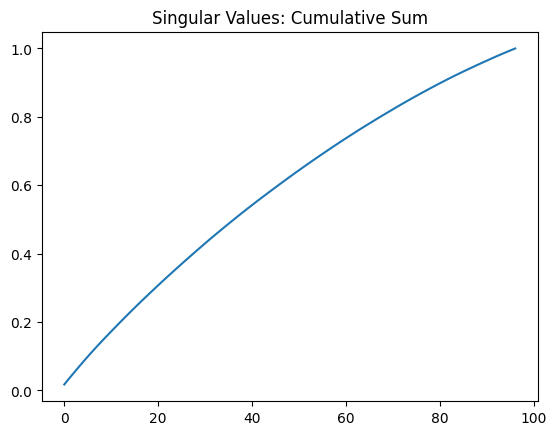

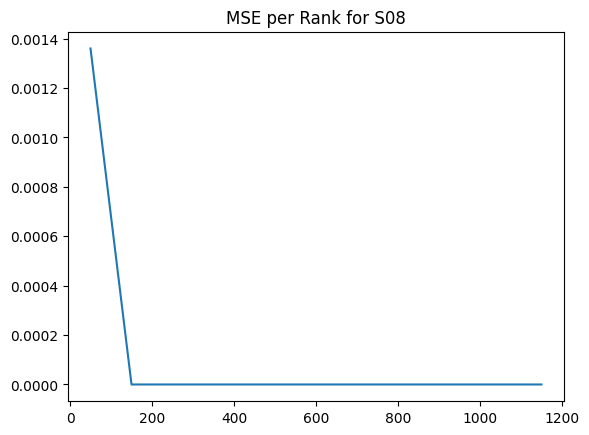

S23 has 127 files
(1250, 127) (127, 127) (127, 127)


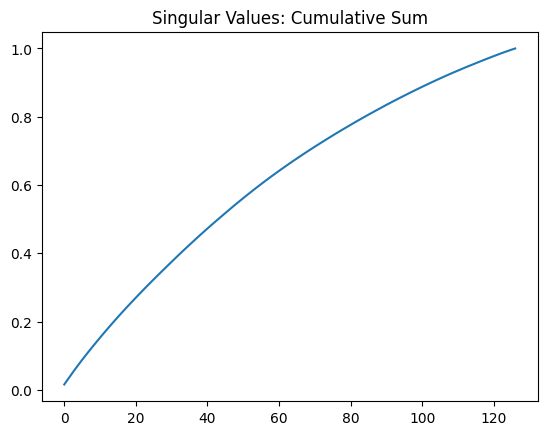

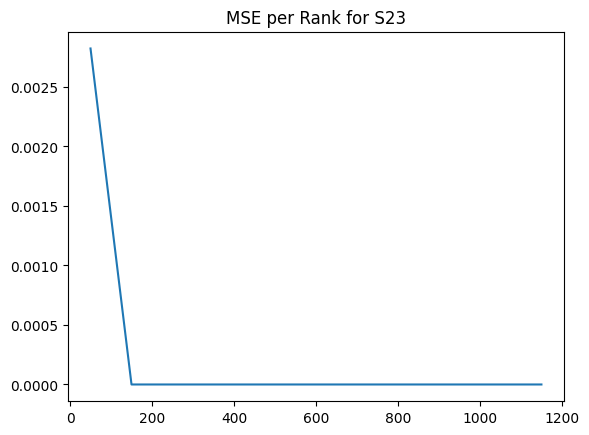

patient number 75 doesn't have any training data
S86 has 243 files
(1250, 243) (243, 243) (243, 243)


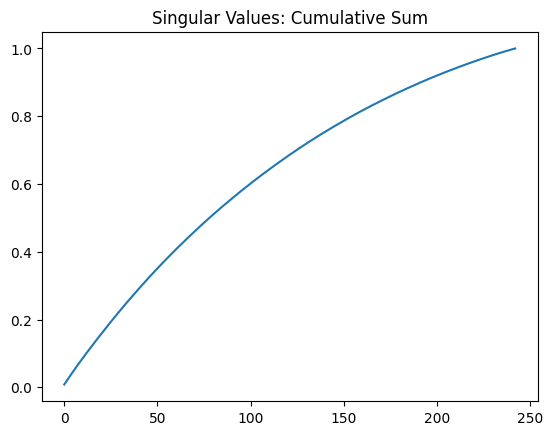

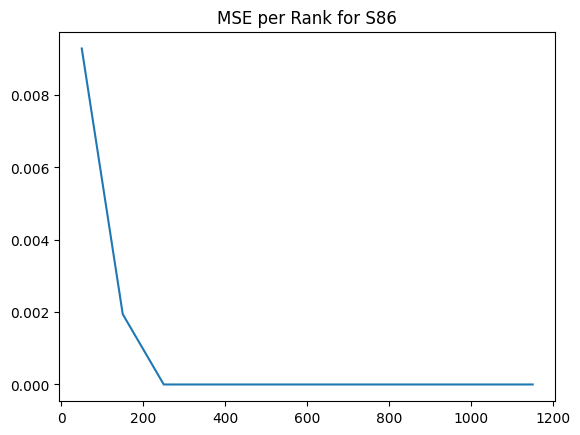

S58 has 162 files
(1250, 162) (162, 162) (162, 162)


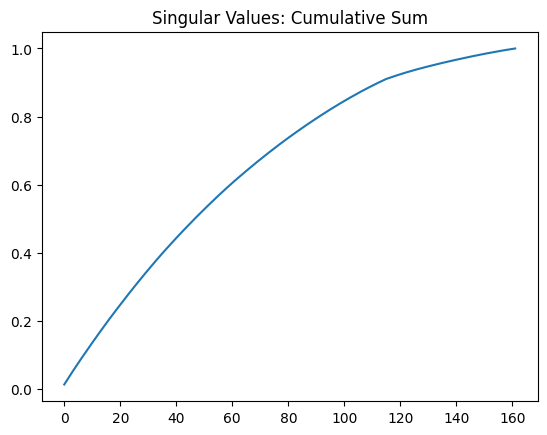

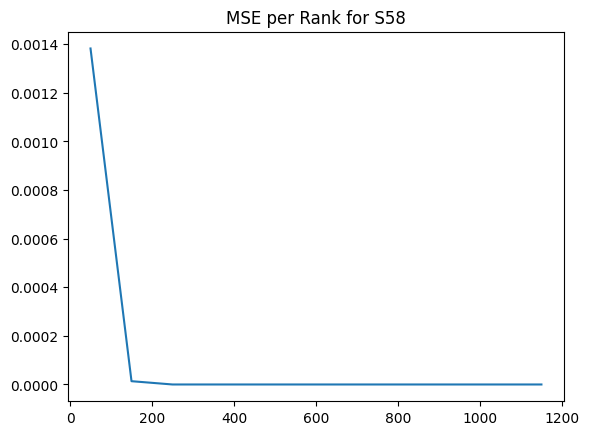

S90 has 37 files
(1250, 37) (37, 37) (37, 37)


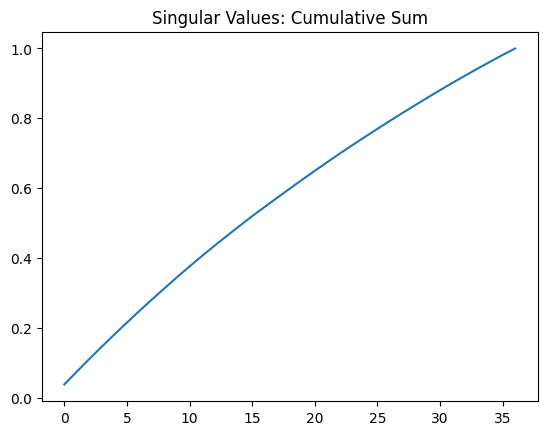

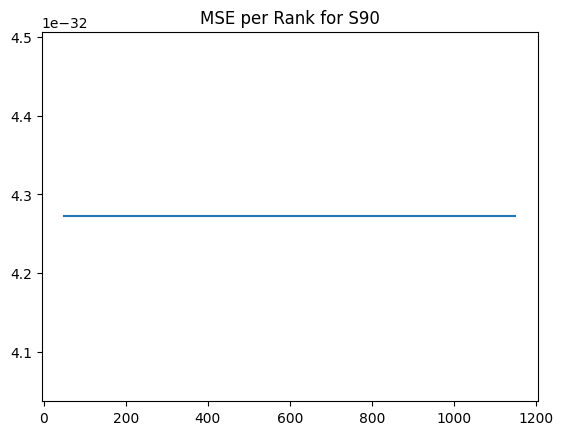

patient number 45 doesn't have any training data
patient number 82 doesn't have any training data
S79 has 155 files
(1250, 155) (155, 155) (155, 155)


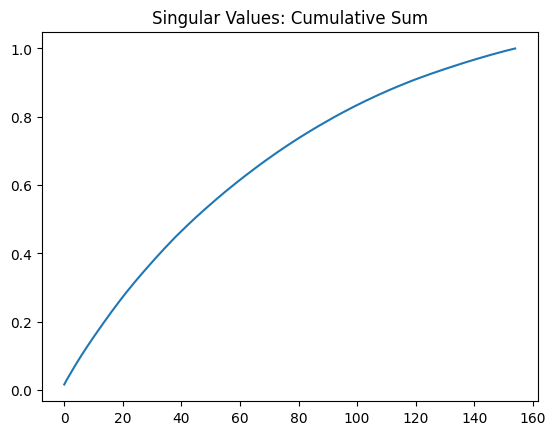

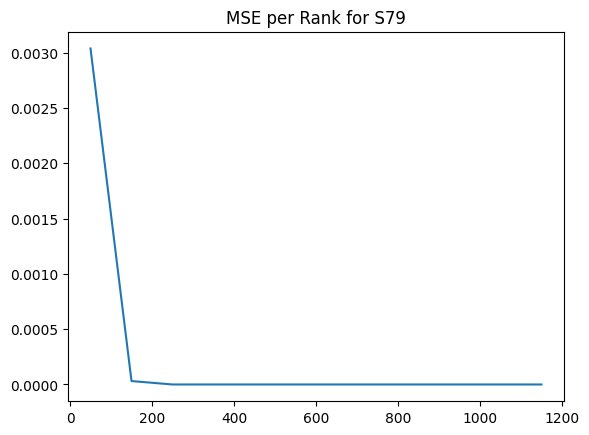

S13 has 27 files
(1250, 27) (27, 27) (27, 27)


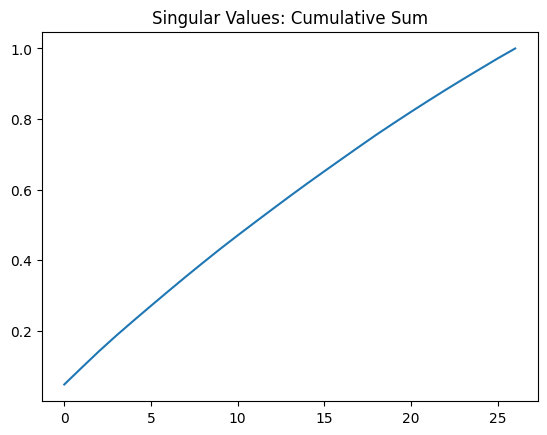

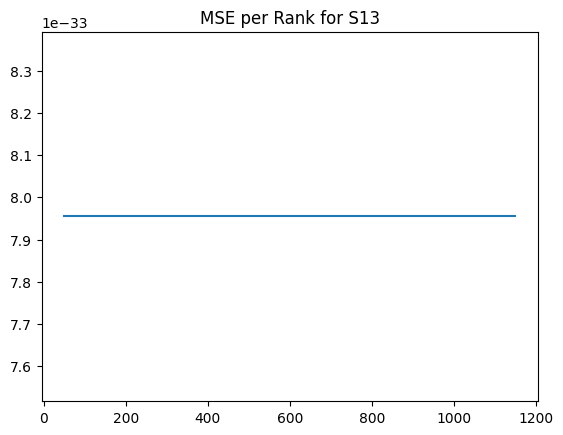

S28 has 383 files
(1250, 383) (383, 383) (383, 383)


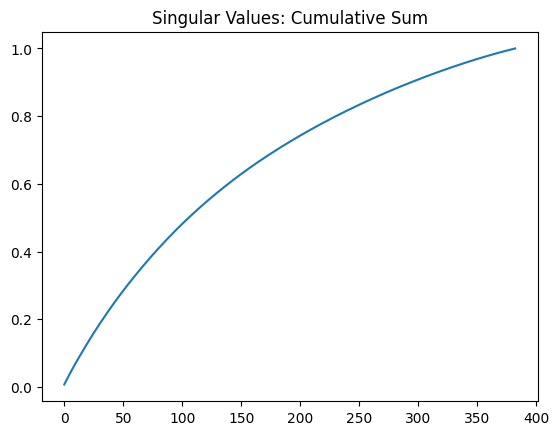

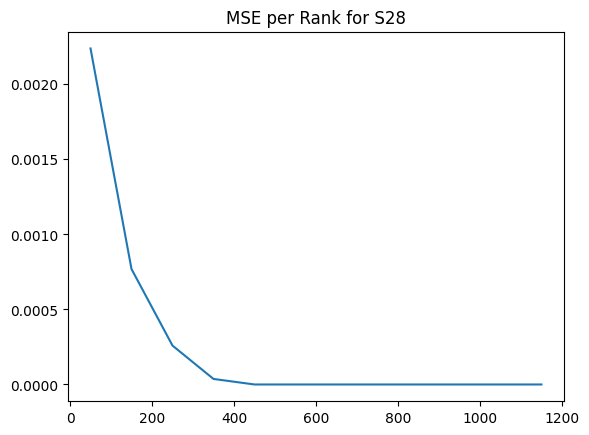

S31 has 167 files
(1250, 167) (167, 167) (167, 167)


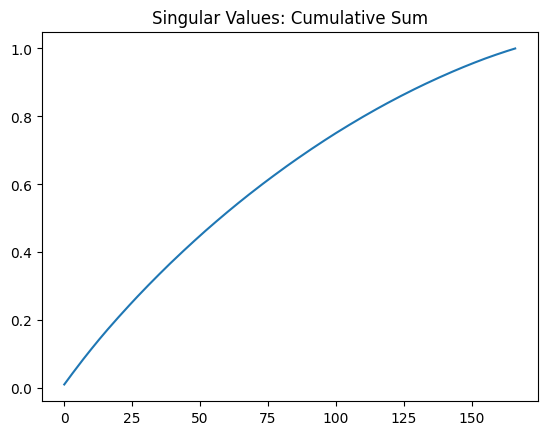

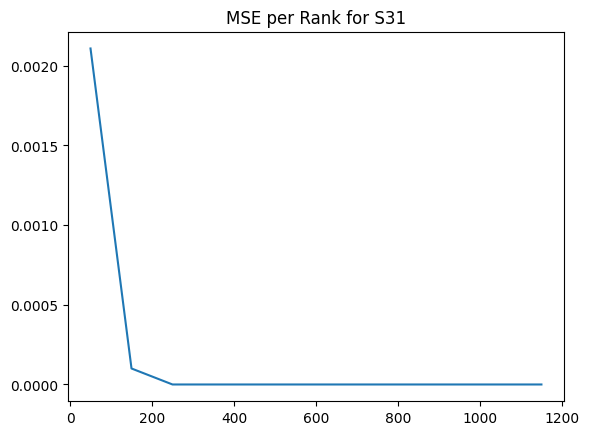

S04 has 94 files
(1250, 94) (94, 94) (94, 94)


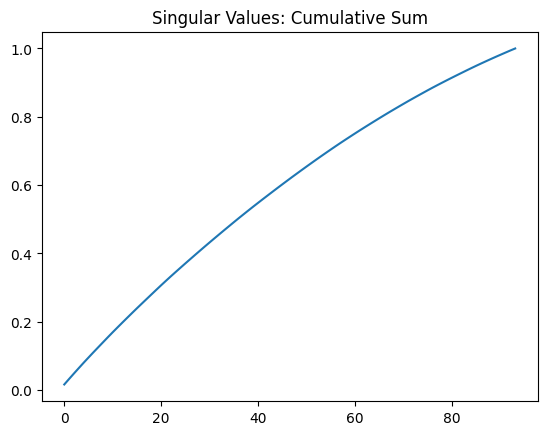

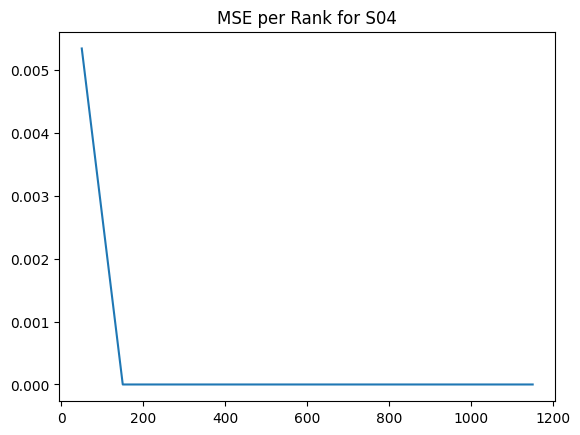

S57 has 15 files
(1250, 15) (15, 15) (15, 15)


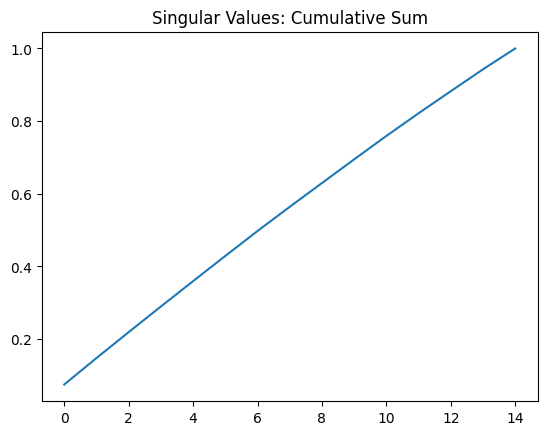

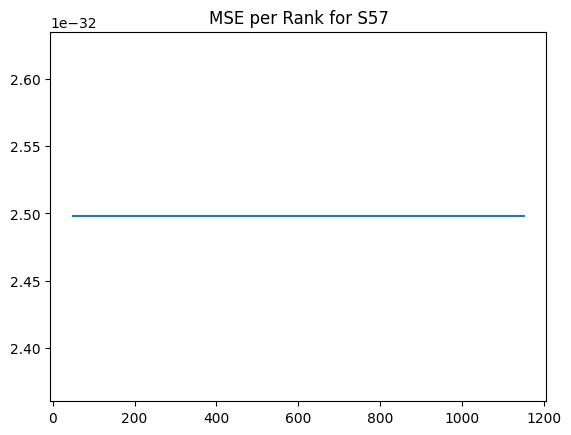

S35 has 554 files
(1250, 554) (554, 554) (554, 554)


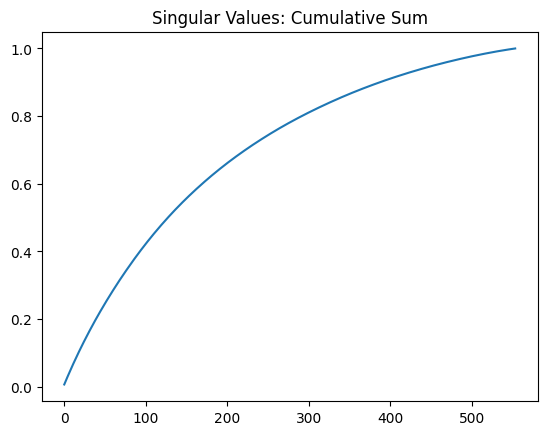

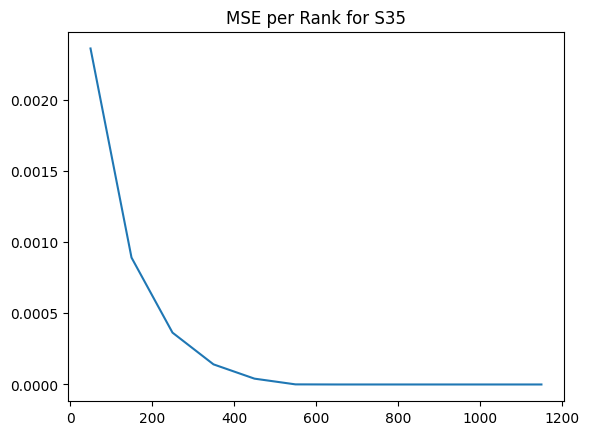

S29 has 150 files
(1250, 150) (150, 150) (150, 150)


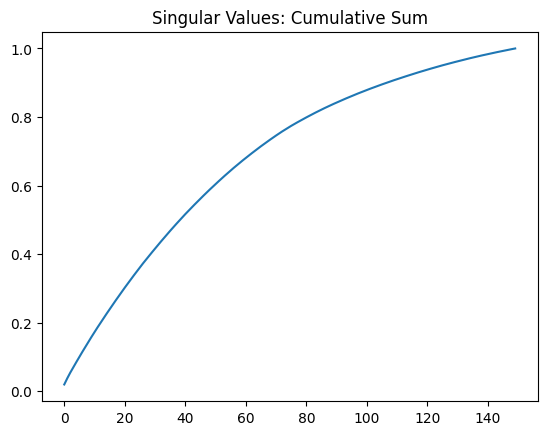

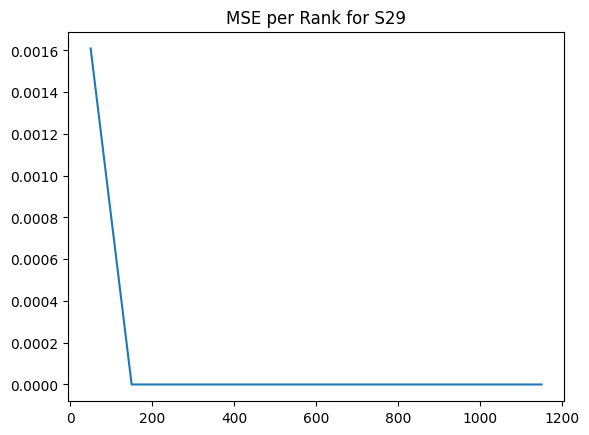

S34 has 253 files
(1250, 253) (253, 253) (253, 253)


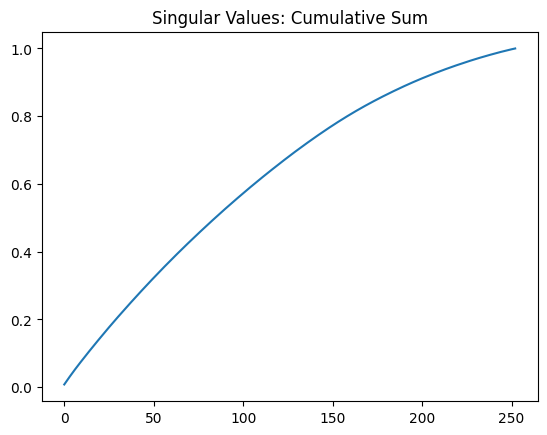

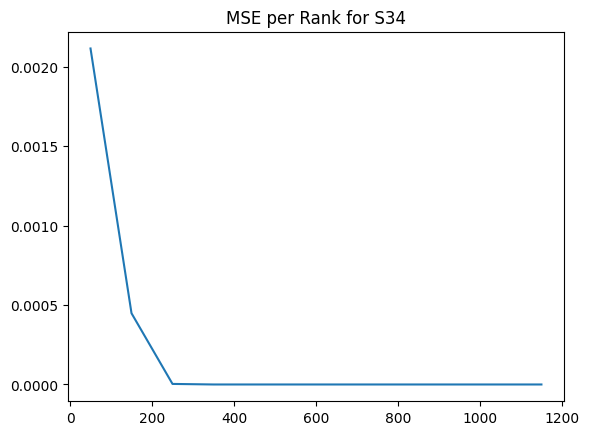

S17 has 98 files
(1250, 98) (98, 98) (98, 98)


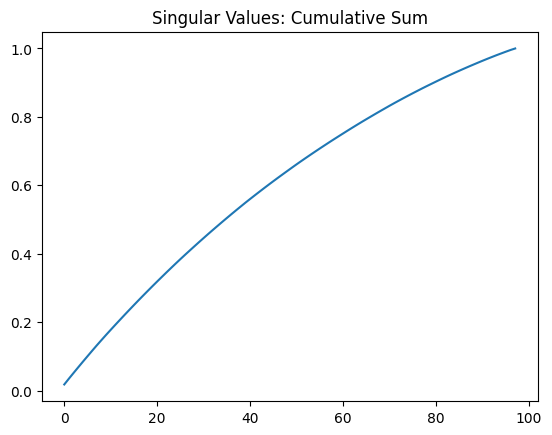

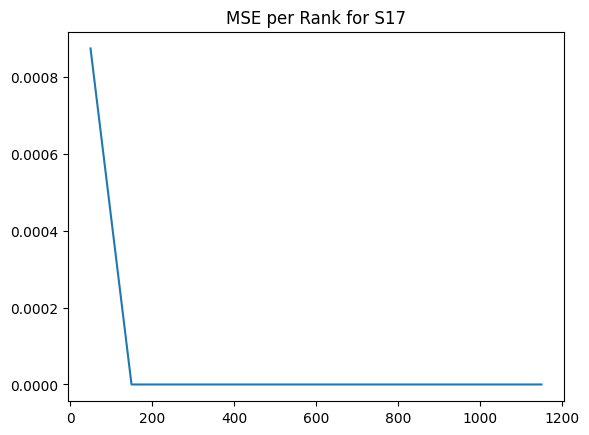

patient number 02 doesn't have any training data
S65 has 100 files
(1250, 100) (100, 100) (100, 100)


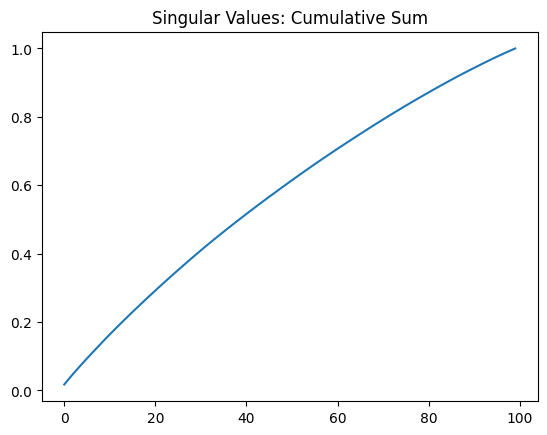

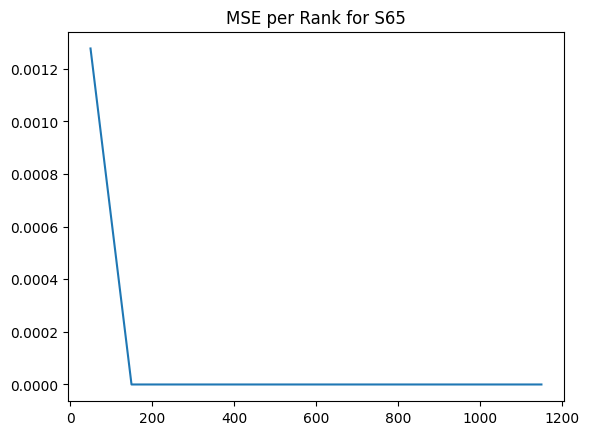

S74 has 176 files
(1250, 176) (176, 176) (176, 176)


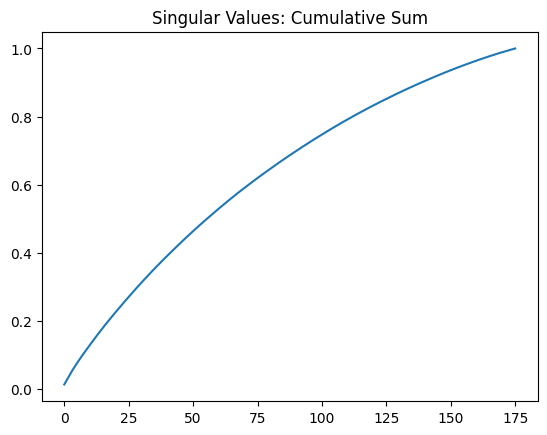

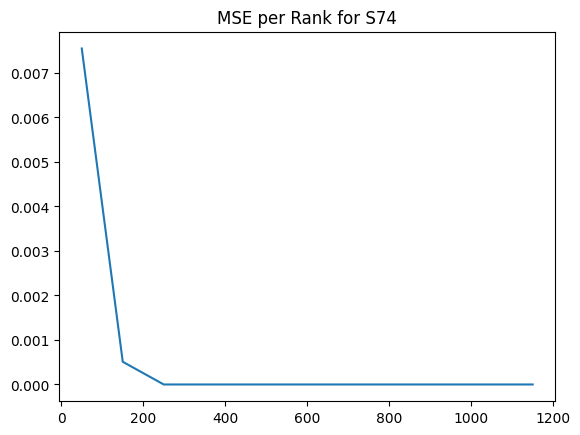

S85 has 46 files
(1250, 46) (46, 46) (46, 46)


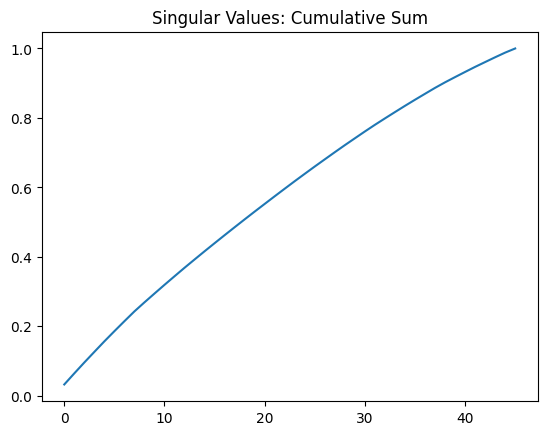

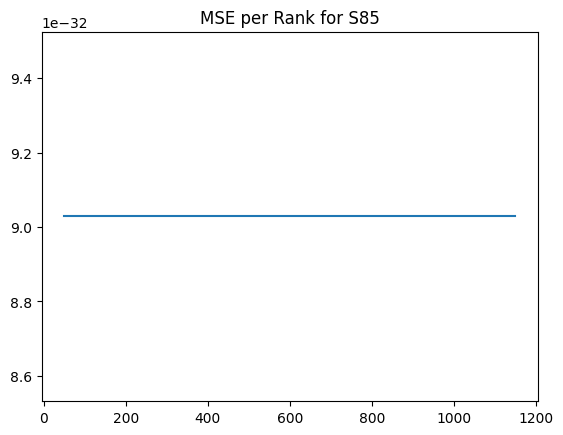

S80 has 119 files
(1250, 119) (119, 119) (119, 119)


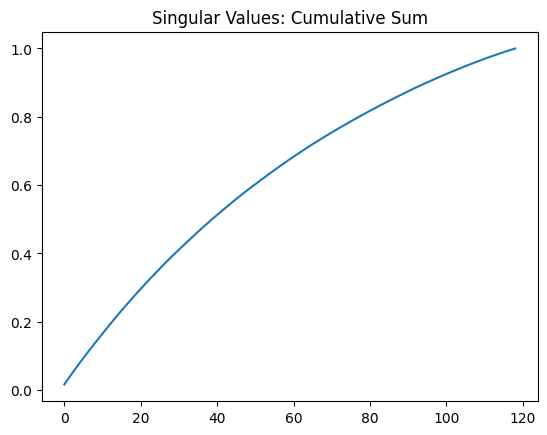

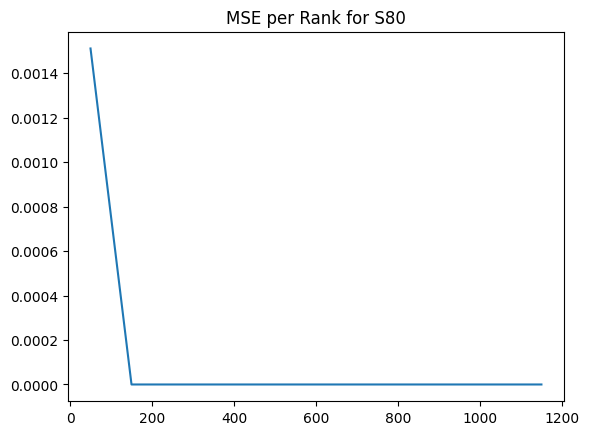

S62 has 214 files
(1250, 214) (214, 214) (214, 214)


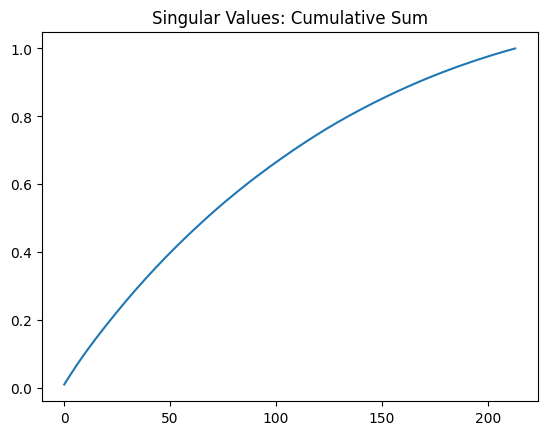

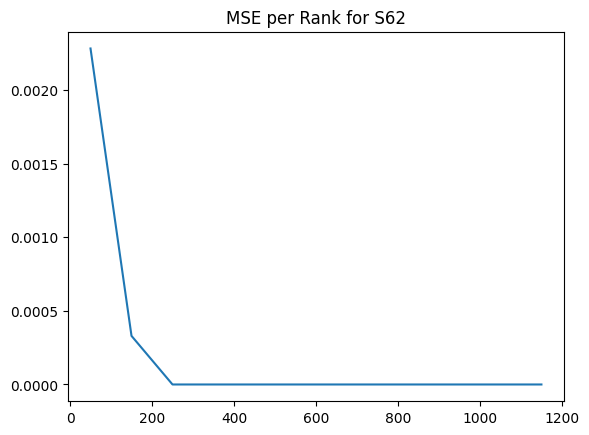

S20 has 634 files
(1250, 634) (634, 634) (634, 634)


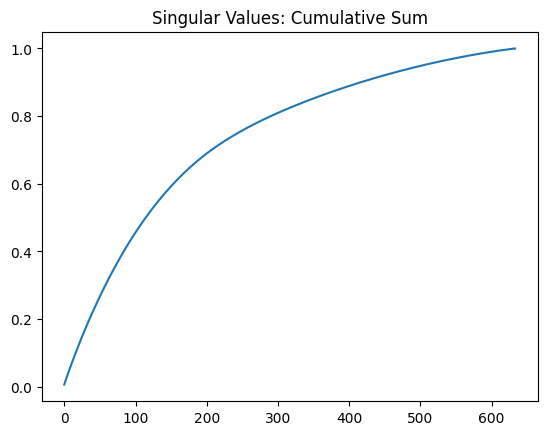

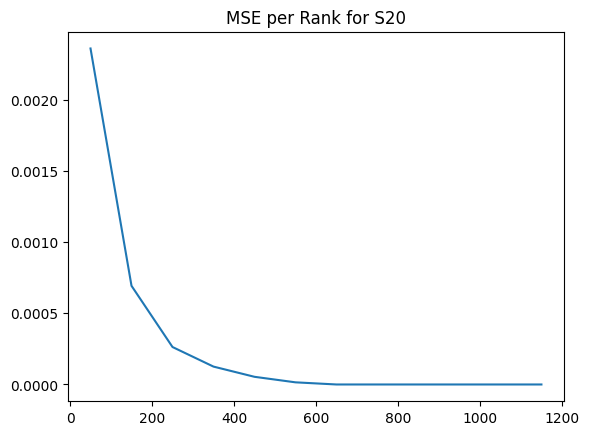

patient number 76 doesn't have any training data
S91 has 119 files
(1250, 119) (119, 119) (119, 119)


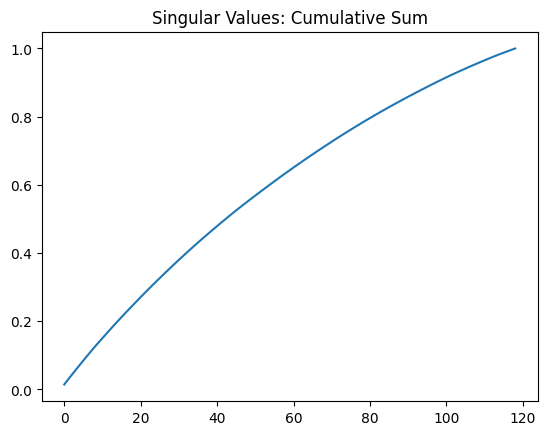

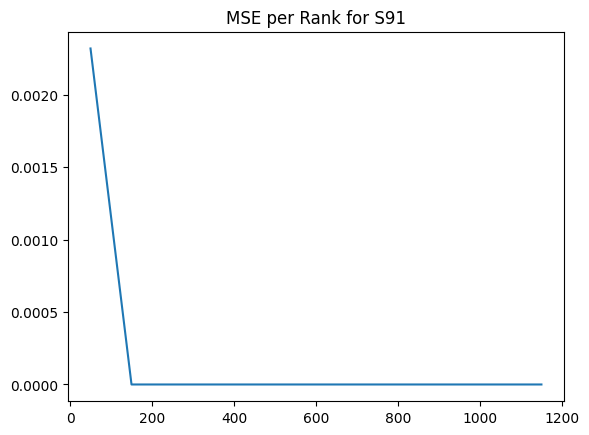

S73 has 99 files
(1250, 99) (99, 99) (99, 99)


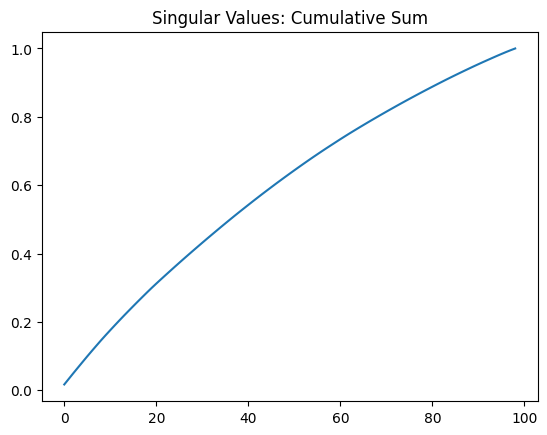

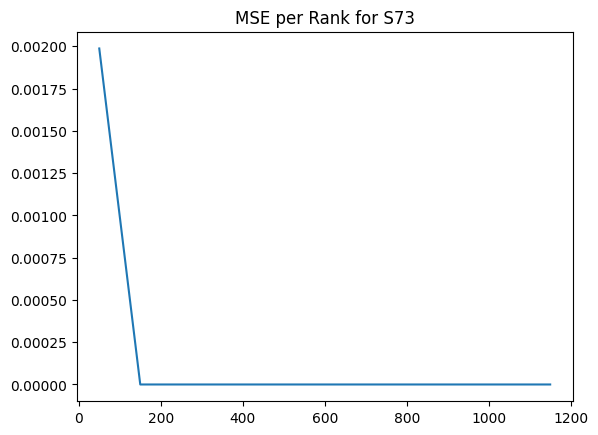

patient number 12 doesn't have any training data
S16 has 99 files
(1250, 99) (99, 99) (99, 99)


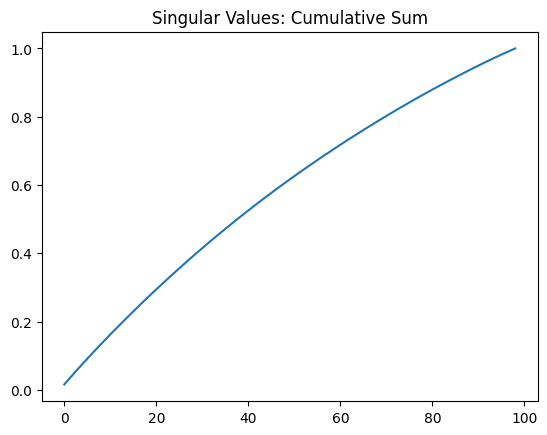

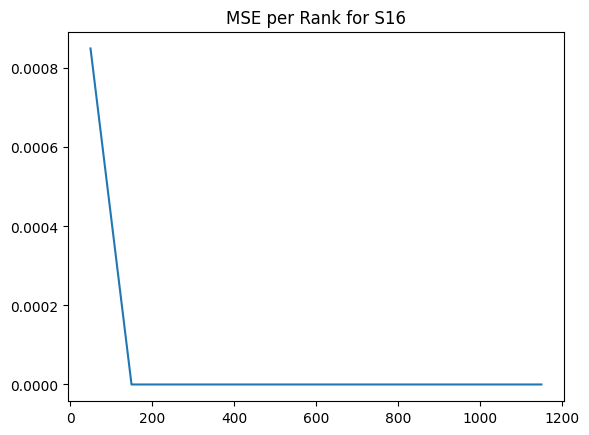

S43 has 90 files
(1250, 90) (90, 90) (90, 90)


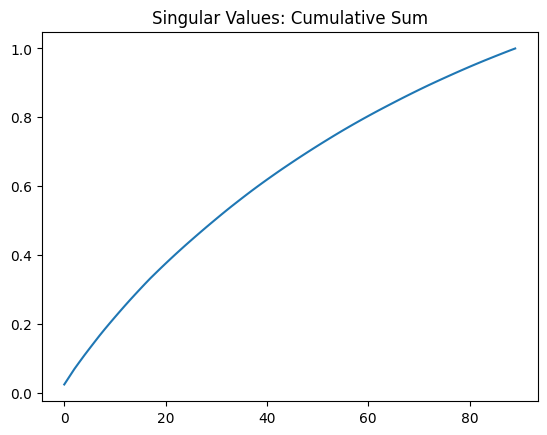

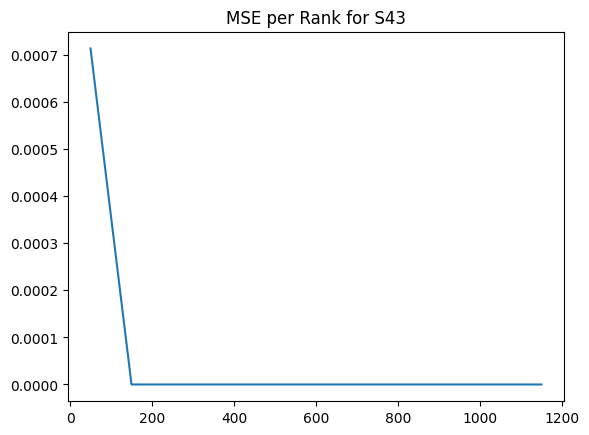

S77 has 140 files
(1250, 140) (140, 140) (140, 140)


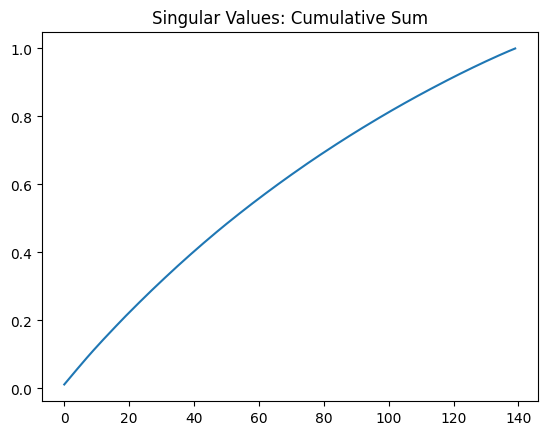

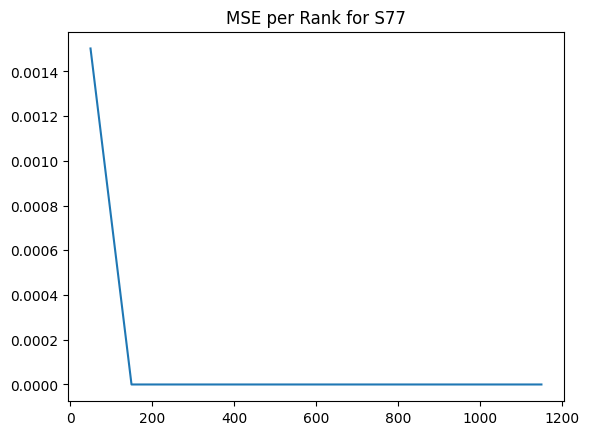

patient number 68 doesn't have any training data
S72 has 105 files
(1250, 105) (105, 105) (105, 105)


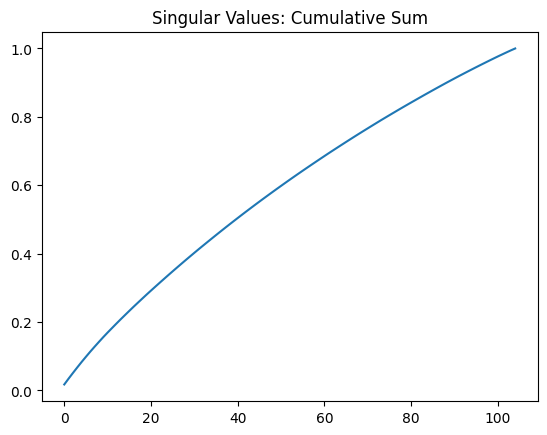

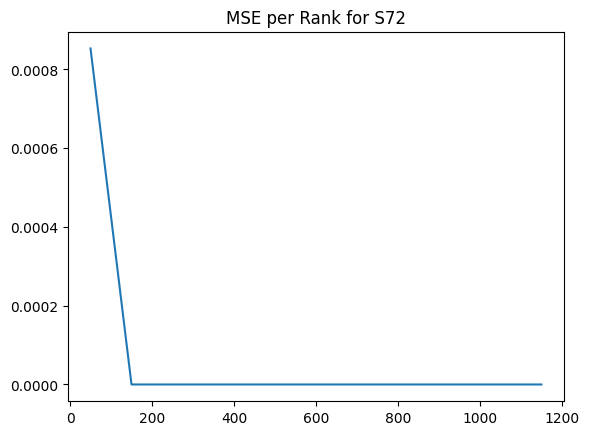

S30 has 174 files
(1250, 174) (174, 174) (174, 174)


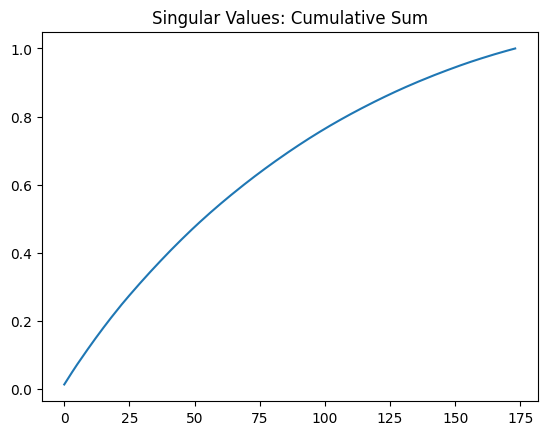

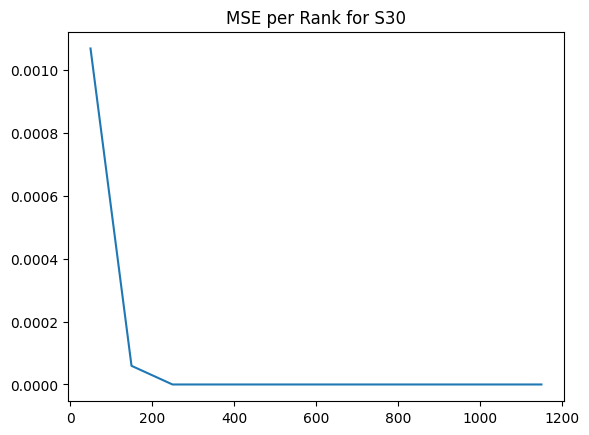

S24 has 142 files
(1250, 142) (142, 142) (142, 142)


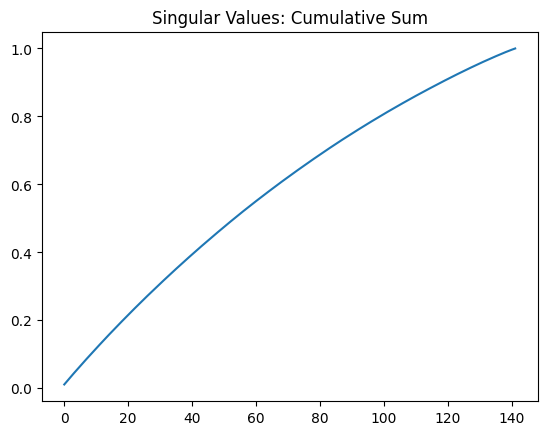

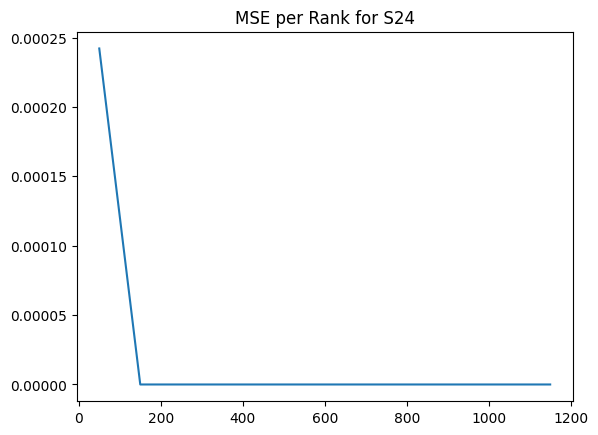

S66 has 113 files
(1250, 113) (113, 113) (113, 113)


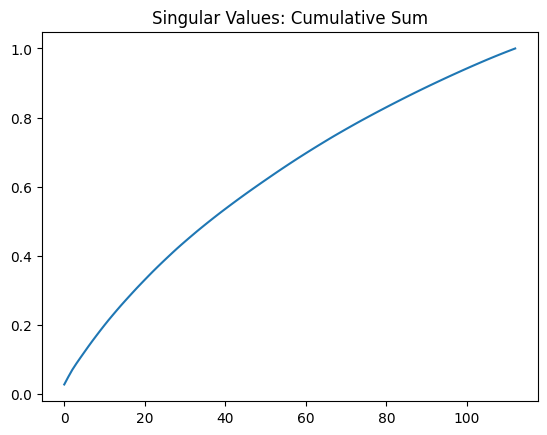

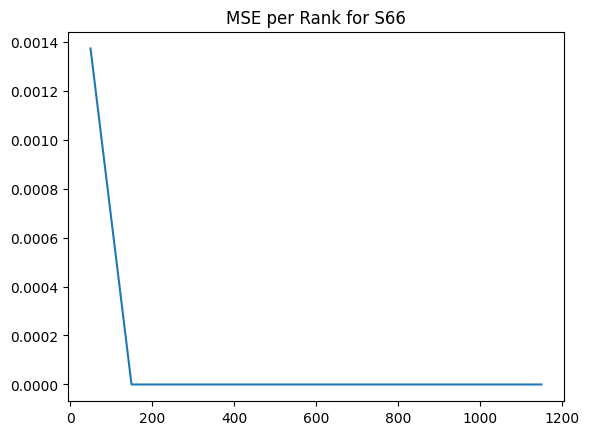

S88 has 147 files
(1250, 147) (147, 147) (147, 147)


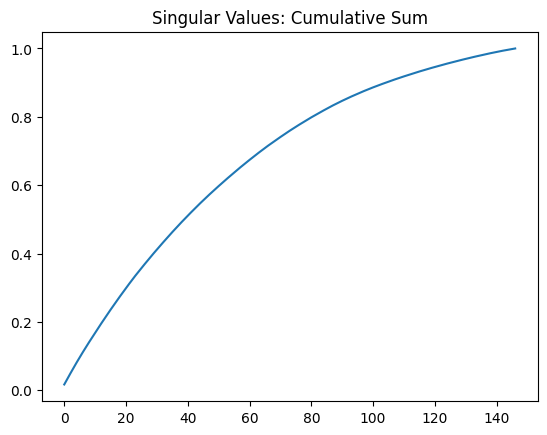

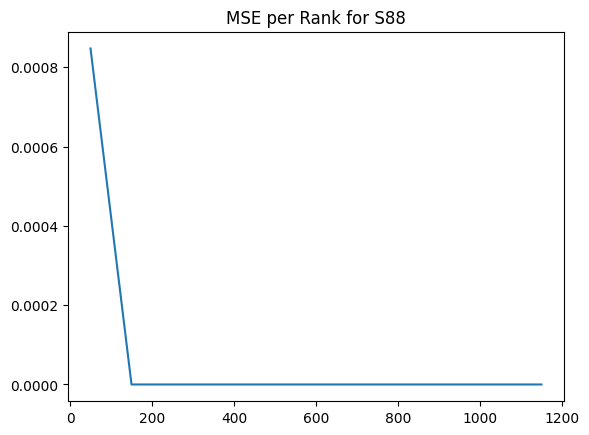

S32 has 138 files
(1250, 138) (138, 138) (138, 138)


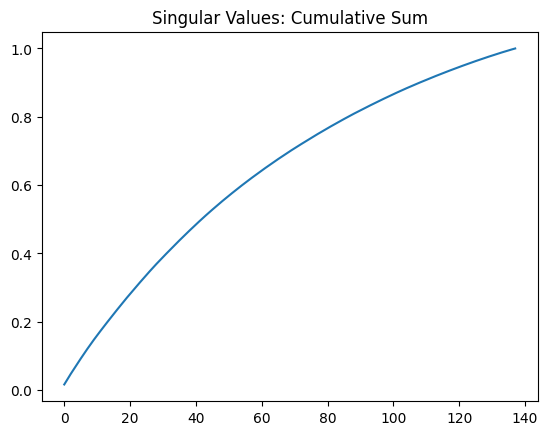

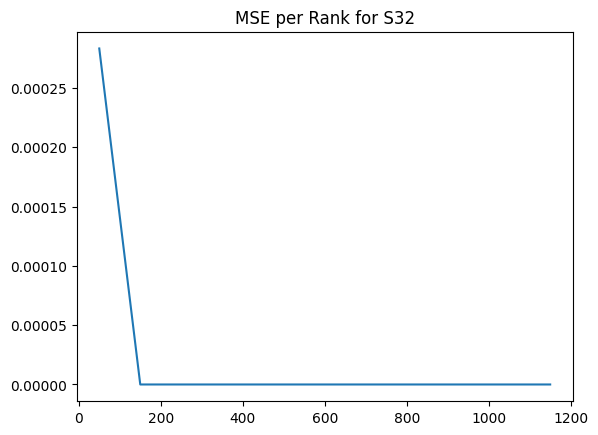

patient number 48 doesn't have any training data
S89 has 136 files
(1250, 136) (136, 136) (136, 136)


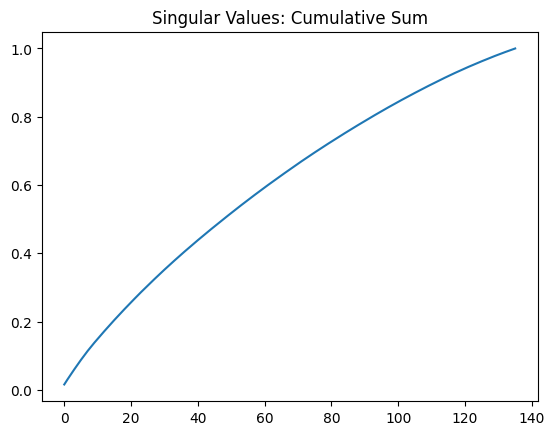

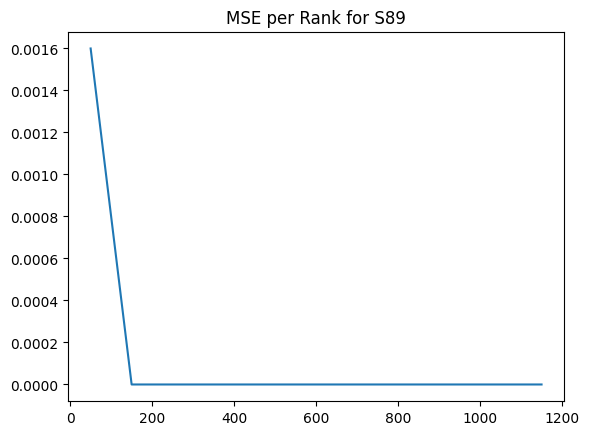

S56 has 137 files
(1250, 137) (137, 137) (137, 137)


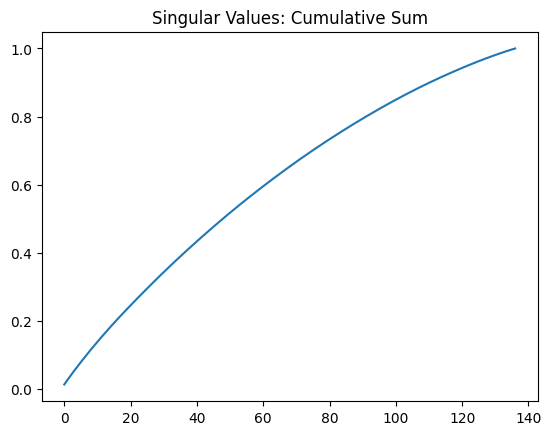

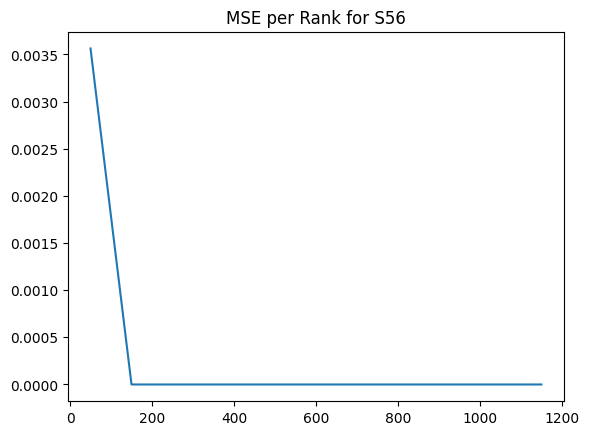

patient number 40 doesn't have any training data
S46 has 357 files
(1250, 357) (357, 357) (357, 357)


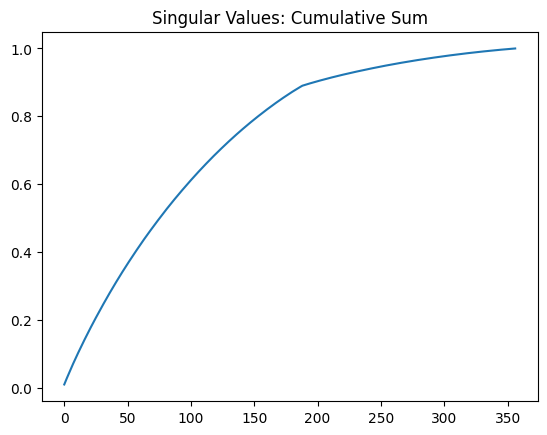

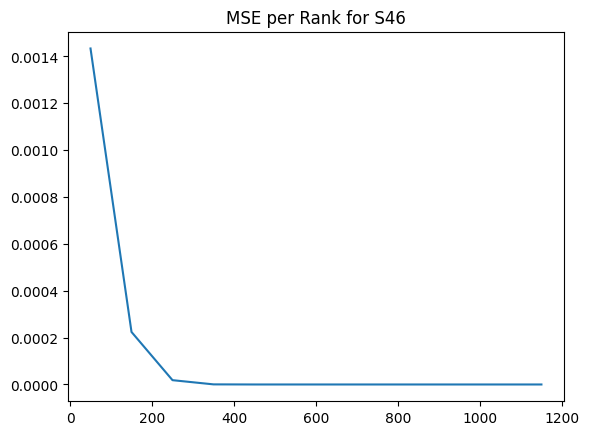

S64 has 221 files
(1250, 221) (221, 221) (221, 221)


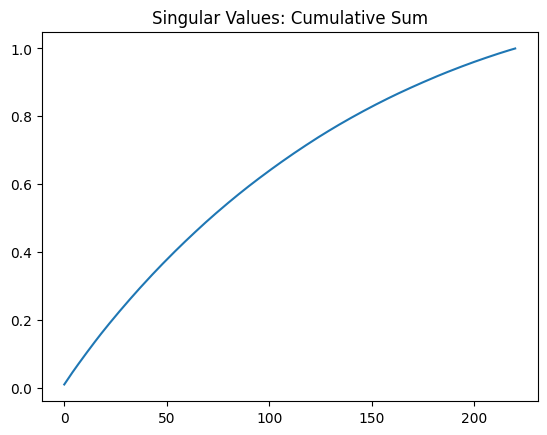

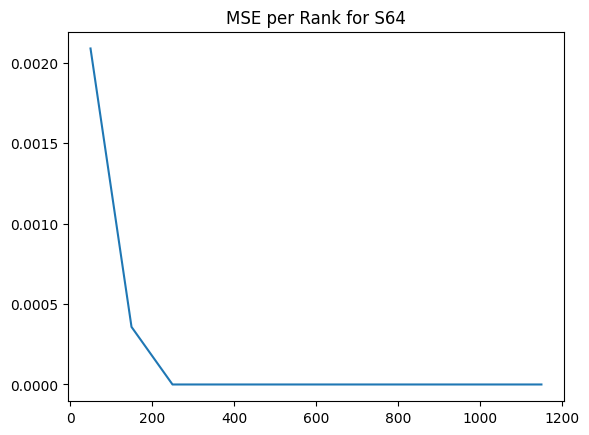

patient number 59 doesn't have any training data
S26 has 668 files
(1250, 668) (668, 668) (668, 668)


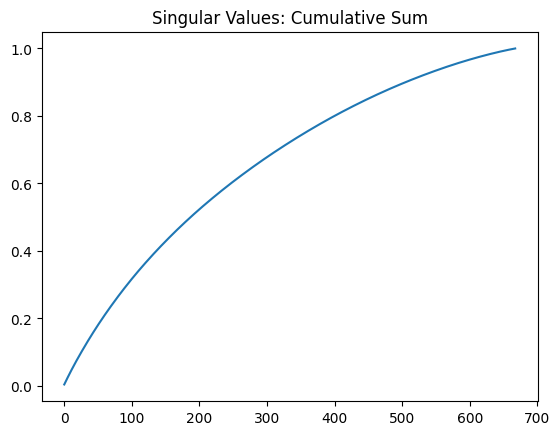

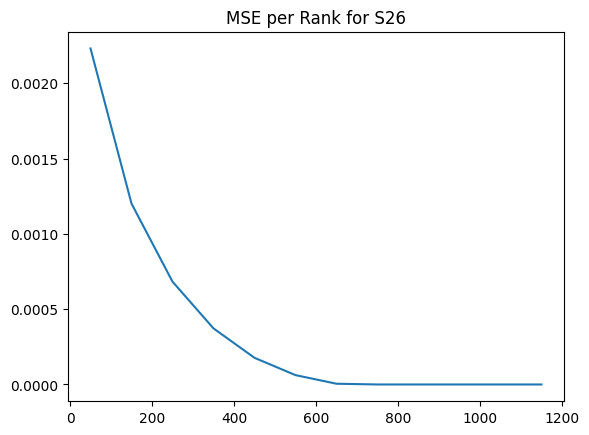

In [43]:
r = 500
p = 500

for pn in patient_nums:
    arr = [np.loadtxt(os.path.join(dir_path, file)) for file in df_train_indices.Filename if file.split('-')[0][1:] == pn and file.split('-')[1] == 'SR' ]
    if len(arr):
        patient_training = np.stack(arr, axis=1)
        print(f"S{pn} has {patient_training.shape[1]} files")
    
        #setup = processData(patient_training, "S"+pn, r = r, p = p)
        U, S, VT = np.linalg.svd(patient_training, full_matrices=False) #full_matrices=False
        S = np.diag(S)
        
        print(U.shape, S.shape, VT.shape)
        ranks = []
        mses = []
        
        for r in range(50, 1250, 100):
            Xapprox = U[:,:r] @ S[:r,:r] @ VT[:r,:]
            mse = np.mean((patient_training - Xapprox) ** 2)
            ranks.append(r)
            mses.append(mse)
            
        plotCumSum(S)
        plt.plot(ranks, mses)
        plt.title(f'MSE per Rank for S{pn}')
        plt.show()
    else:
        print(f"patient number {pn} doesn't have any training data")